## Harmonic oscillator simulation with and without order-compensating coordinate transformation

Symplectic Euler method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, newton

In [2]:
q0 = 1
p0 = 0

def H(q,p):
    return 1/2 * p**2 + 1/2 * q**2

def H_q(q,p):
    return q

def H_p(q,p):
    return p

def exact_solution(t):
    return np.array(
        [
            np.cos(t),
            -np.sin(t),
        ]
    )

In [3]:
J = 1000
h = 0.3
t = np.array(range(0, J+1))*h

In [4]:
q = np.zeros(J+1)
p = np.zeros(J+1)

q[0] = q0
p[0] = p0

for j in range(0, J):
    p[j+1] = p[j] - h*H_q(q[j], None)
    q[j+1] = q[j] + h*H_p(None, p[j+1])

In [5]:
k = 2

In [6]:
def qm(q):
    return q / (1 + k*h**2)
    
def Q(q):
    qhat = qm(q)
    return 2 / np.pi * ( qhat * np.sqrt(1 - qhat**2) + np.arcsin(qhat) )
    
def dQdq(q):
    return 4 / np.pi * np.sqrt(1 - (q**2)/(1 + h**2*k)**2) / (1 + h**2 * k)

def d2Qdq2(q):
    return - 4 / np.pi * q / (1 + h**2 * k)**3 / np.sqrt(1 - q**2 / (1 + h**2 * k)**2)

def Qinv(qbar):
    return newton(lambda q: Q(q) - qbar, x0=0, fprime=dQdq)

def dQinvdqbar(qbar):
    return 1/(dQdq(Qinv(qbar)))

def P(q, p):
    return p * (dQinvdqbar(Q(q)))

def Pinv(qbar, pbar):
    return pbar * (dQdq(Qinv(qbar)))

def Hbar(qbar, pbar):
    return 1/2 * Pinv(qbar, pbar)**2 + 1/2 * Qinv(qbar)**2

def Hbar_qbar(qbar, pbar):
    # ezt ellenőrizni, hogy biztos jó-e, ha valami nem stimm
    return pbar**2 * (dQdq(Qinv(qbar))) * d2Qdq2(Qinv(qbar)) * dQinvdqbar(qbar) + Qinv(qbar) * dQinvdqbar(qbar)
 
def Hbar_pbar(qbar, pbar):
    return pbar * (dQdq(Qinv(qbar)))**2

In [9]:
from scipy.optimize import root

In [10]:
from tqdm import tqdm

In [11]:
qbar = np.zeros(J+1)
pbar = np.zeros(J+1)

qbar[0] = Q(q0)
pbar[0] = P(q0, p0)

print(qbar[0], pbar[0])

for j in tqdm(range(0, J)):
    pbar[j+1] = root_scalar(
        lambda pbarjp1: np.real(pbar[j] - h*Hbar_qbar(qbar[j], pbarjp1) - pbarjp1),
        x0=np.real(pbar[j]),
        bracket=[-1, 1],
    ).root
    qbar[j+1] = qbar[j] + h*Hbar_pbar(qbar[j], pbar[j+1])
    # print(qbar[j+1], pbar[j+1])
    # print(Qinv(qbar[j+1]), Pinv(qbar[j+1], pbar[j+1]))
    # print('----')

0.9301407222853565 0.0


100%|██████████| 1000/1000 [00:07<00:00, 131.61it/s]


In [12]:
qbarinv = [Qinv(qbari) for qbari in qbar]
pbarinv = [Pinv(qbari, pbari) for (qbari, pbari) in zip(qbar, pbar)]

In [13]:
np.abs(qbar).max()

0.9363335116057896

In [14]:
np.abs(pbar).max()

0.9345899363337227

In [15]:
fig_width_mm = 80
fig_width_wide_mm = 180
mm_to_in = 0.03937

dpi = 600

linewidth = 0.7

In [16]:
font_size = 9
smaller_font_size = 0.8*font_size

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": font_size,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.constrained_layout.use": True 
    }
)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm} \usepackage[utf8]{inputenc}')

In [31]:
graph_folder = '.'

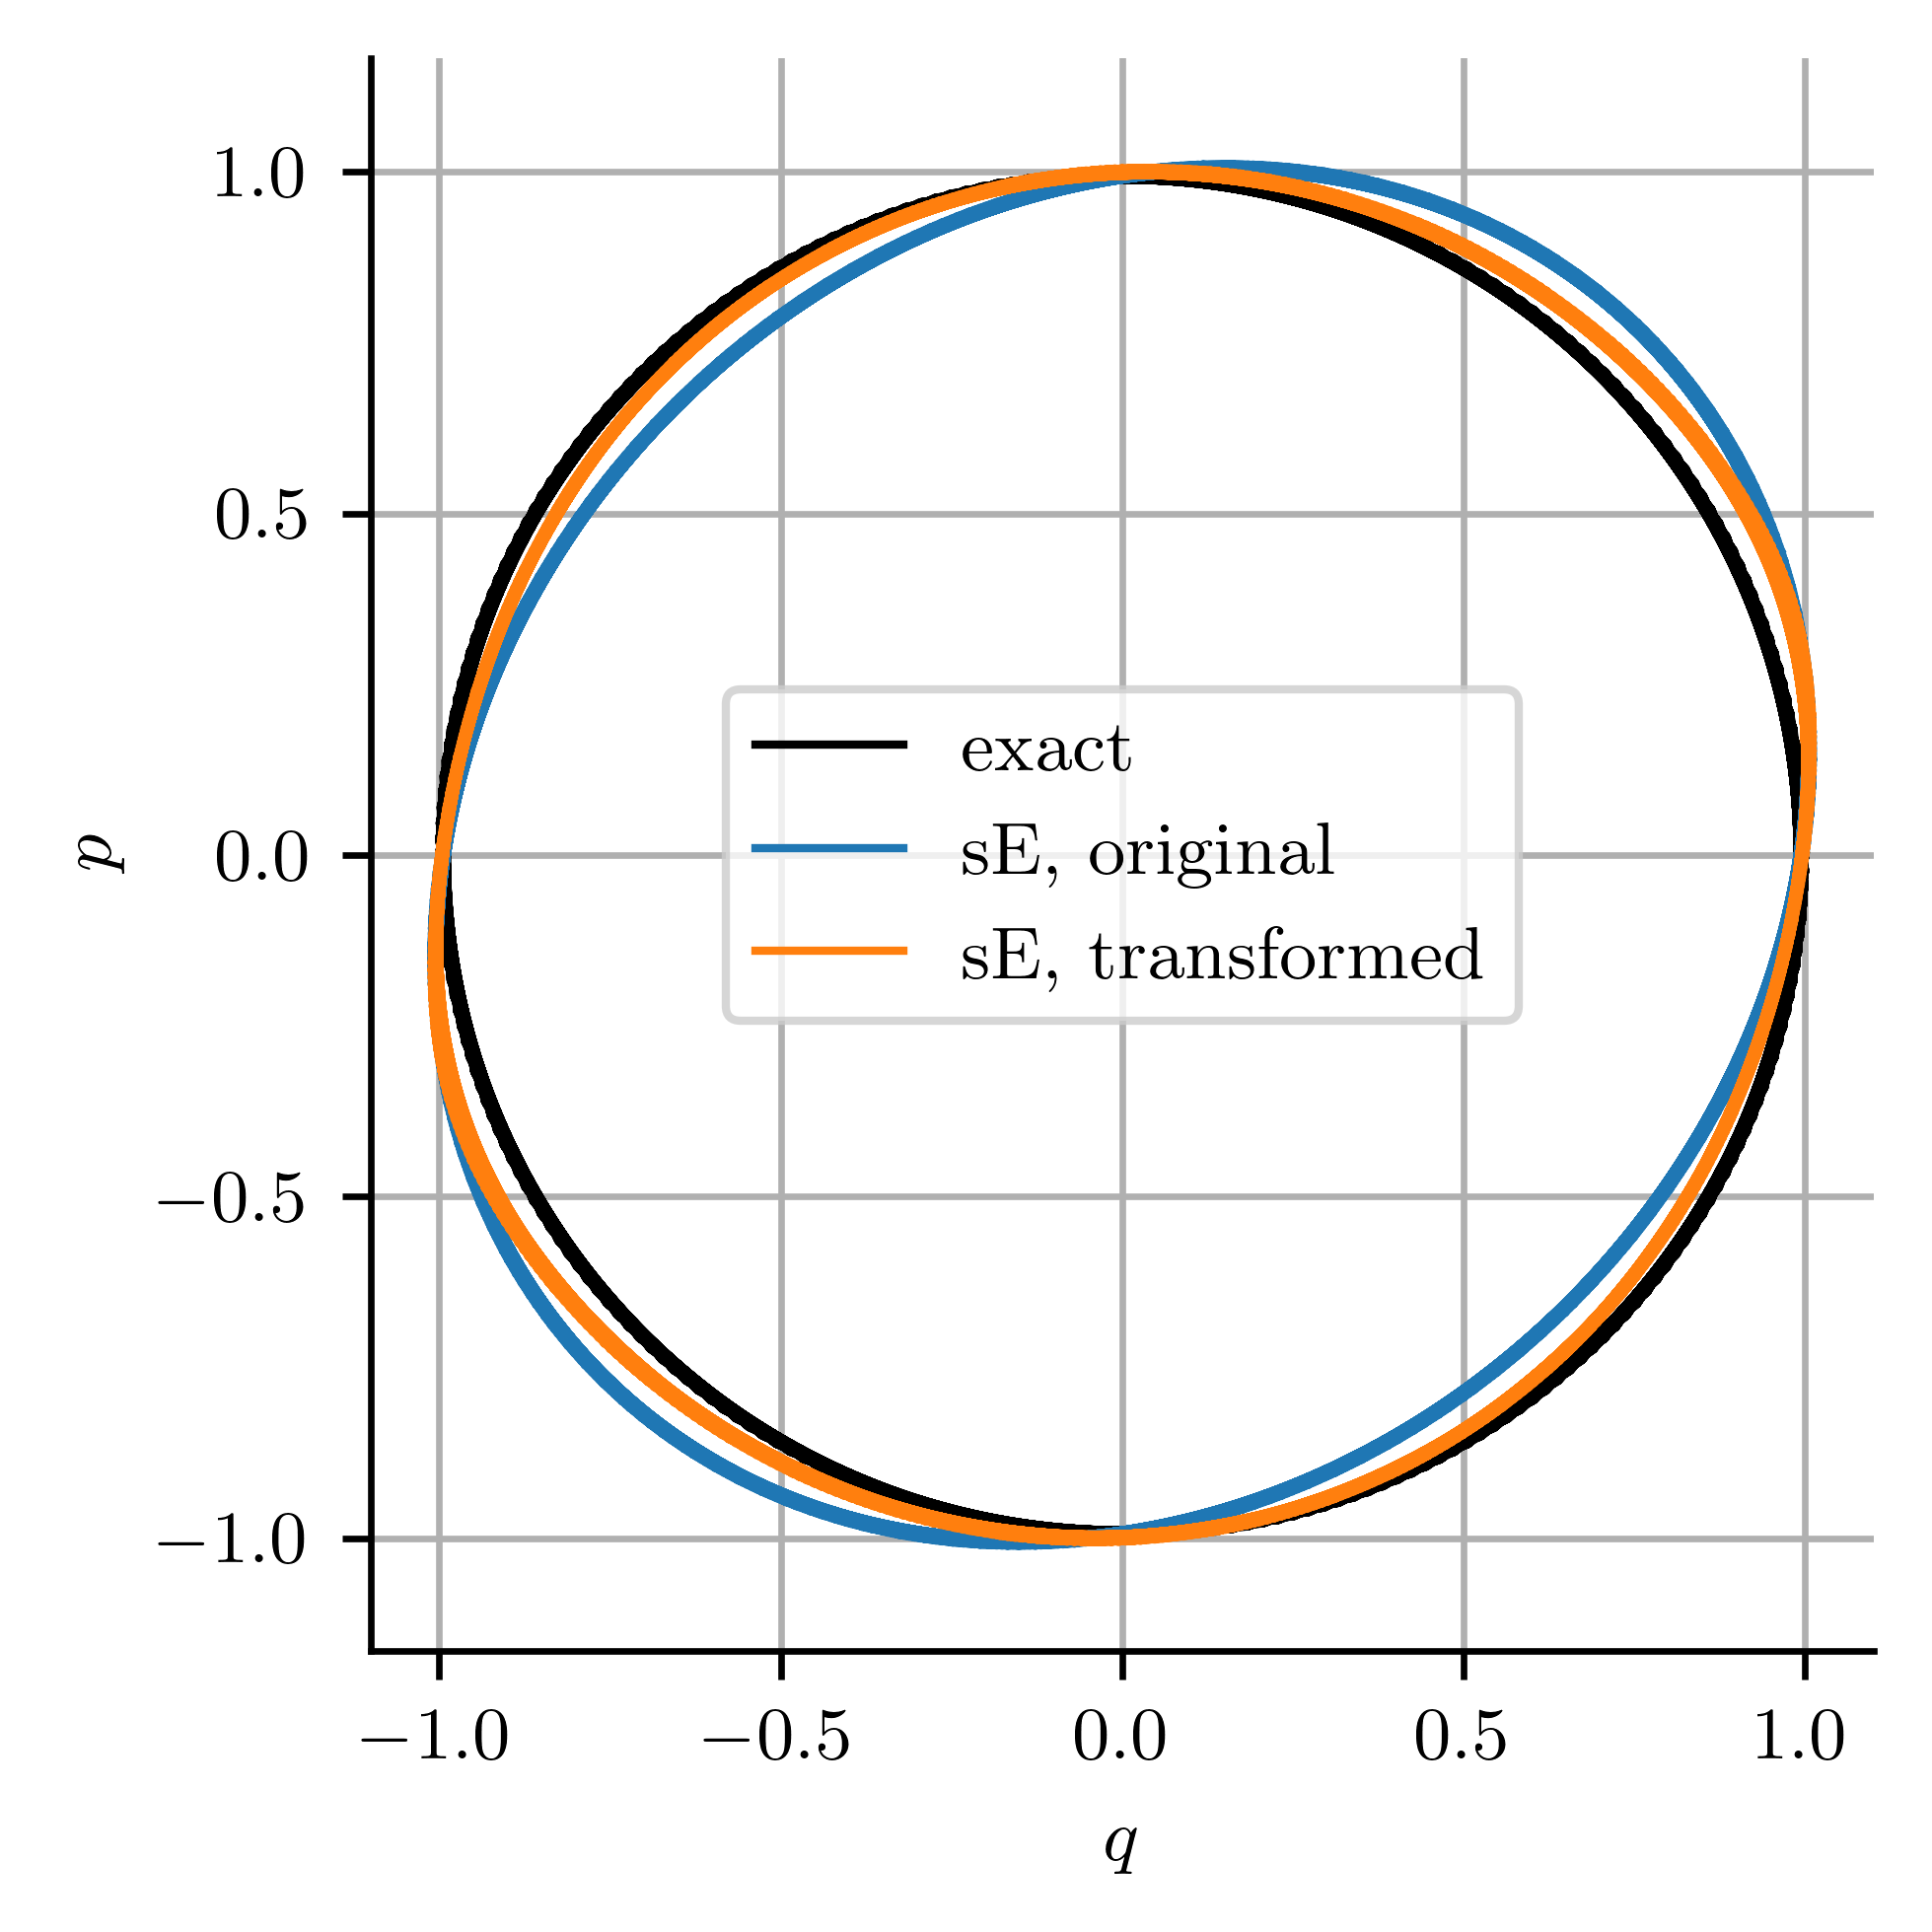

In [32]:
fig, ax = plt.subplots(1,1,figsize=(fig_width_mm*mm_to_in, fig_width_mm*mm_to_in),dpi=dpi)

t_plot = np.linspace(0, h*J, 1000)

ax.plot(*exact_solution(t_plot), color='k', lw=1, label='exact')

ax.plot(q, p, lw=1, label='sE, original')
ax.plot(qbarinv, pbarinv, lw=1, label='sE, transformed')
ax.axis('equal')
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.grid('both')

ax.set_xlabel(r'$$q$$')
ax.set_ylabel(r'$$p$$')

ax.set_axisbelow(True)

ax.legend(loc='center')

plt.savefig(graph_folder + '/harmonic_oscillator_transformed_phasespace.png', bbox_inches='tight', facecolor='white')
plt.show()

In [25]:
Hofbar = [H(qbarinvi, pbarinvi) for (qbarinvi, pbarinvi) in zip(qbarinv, pbarinv)]

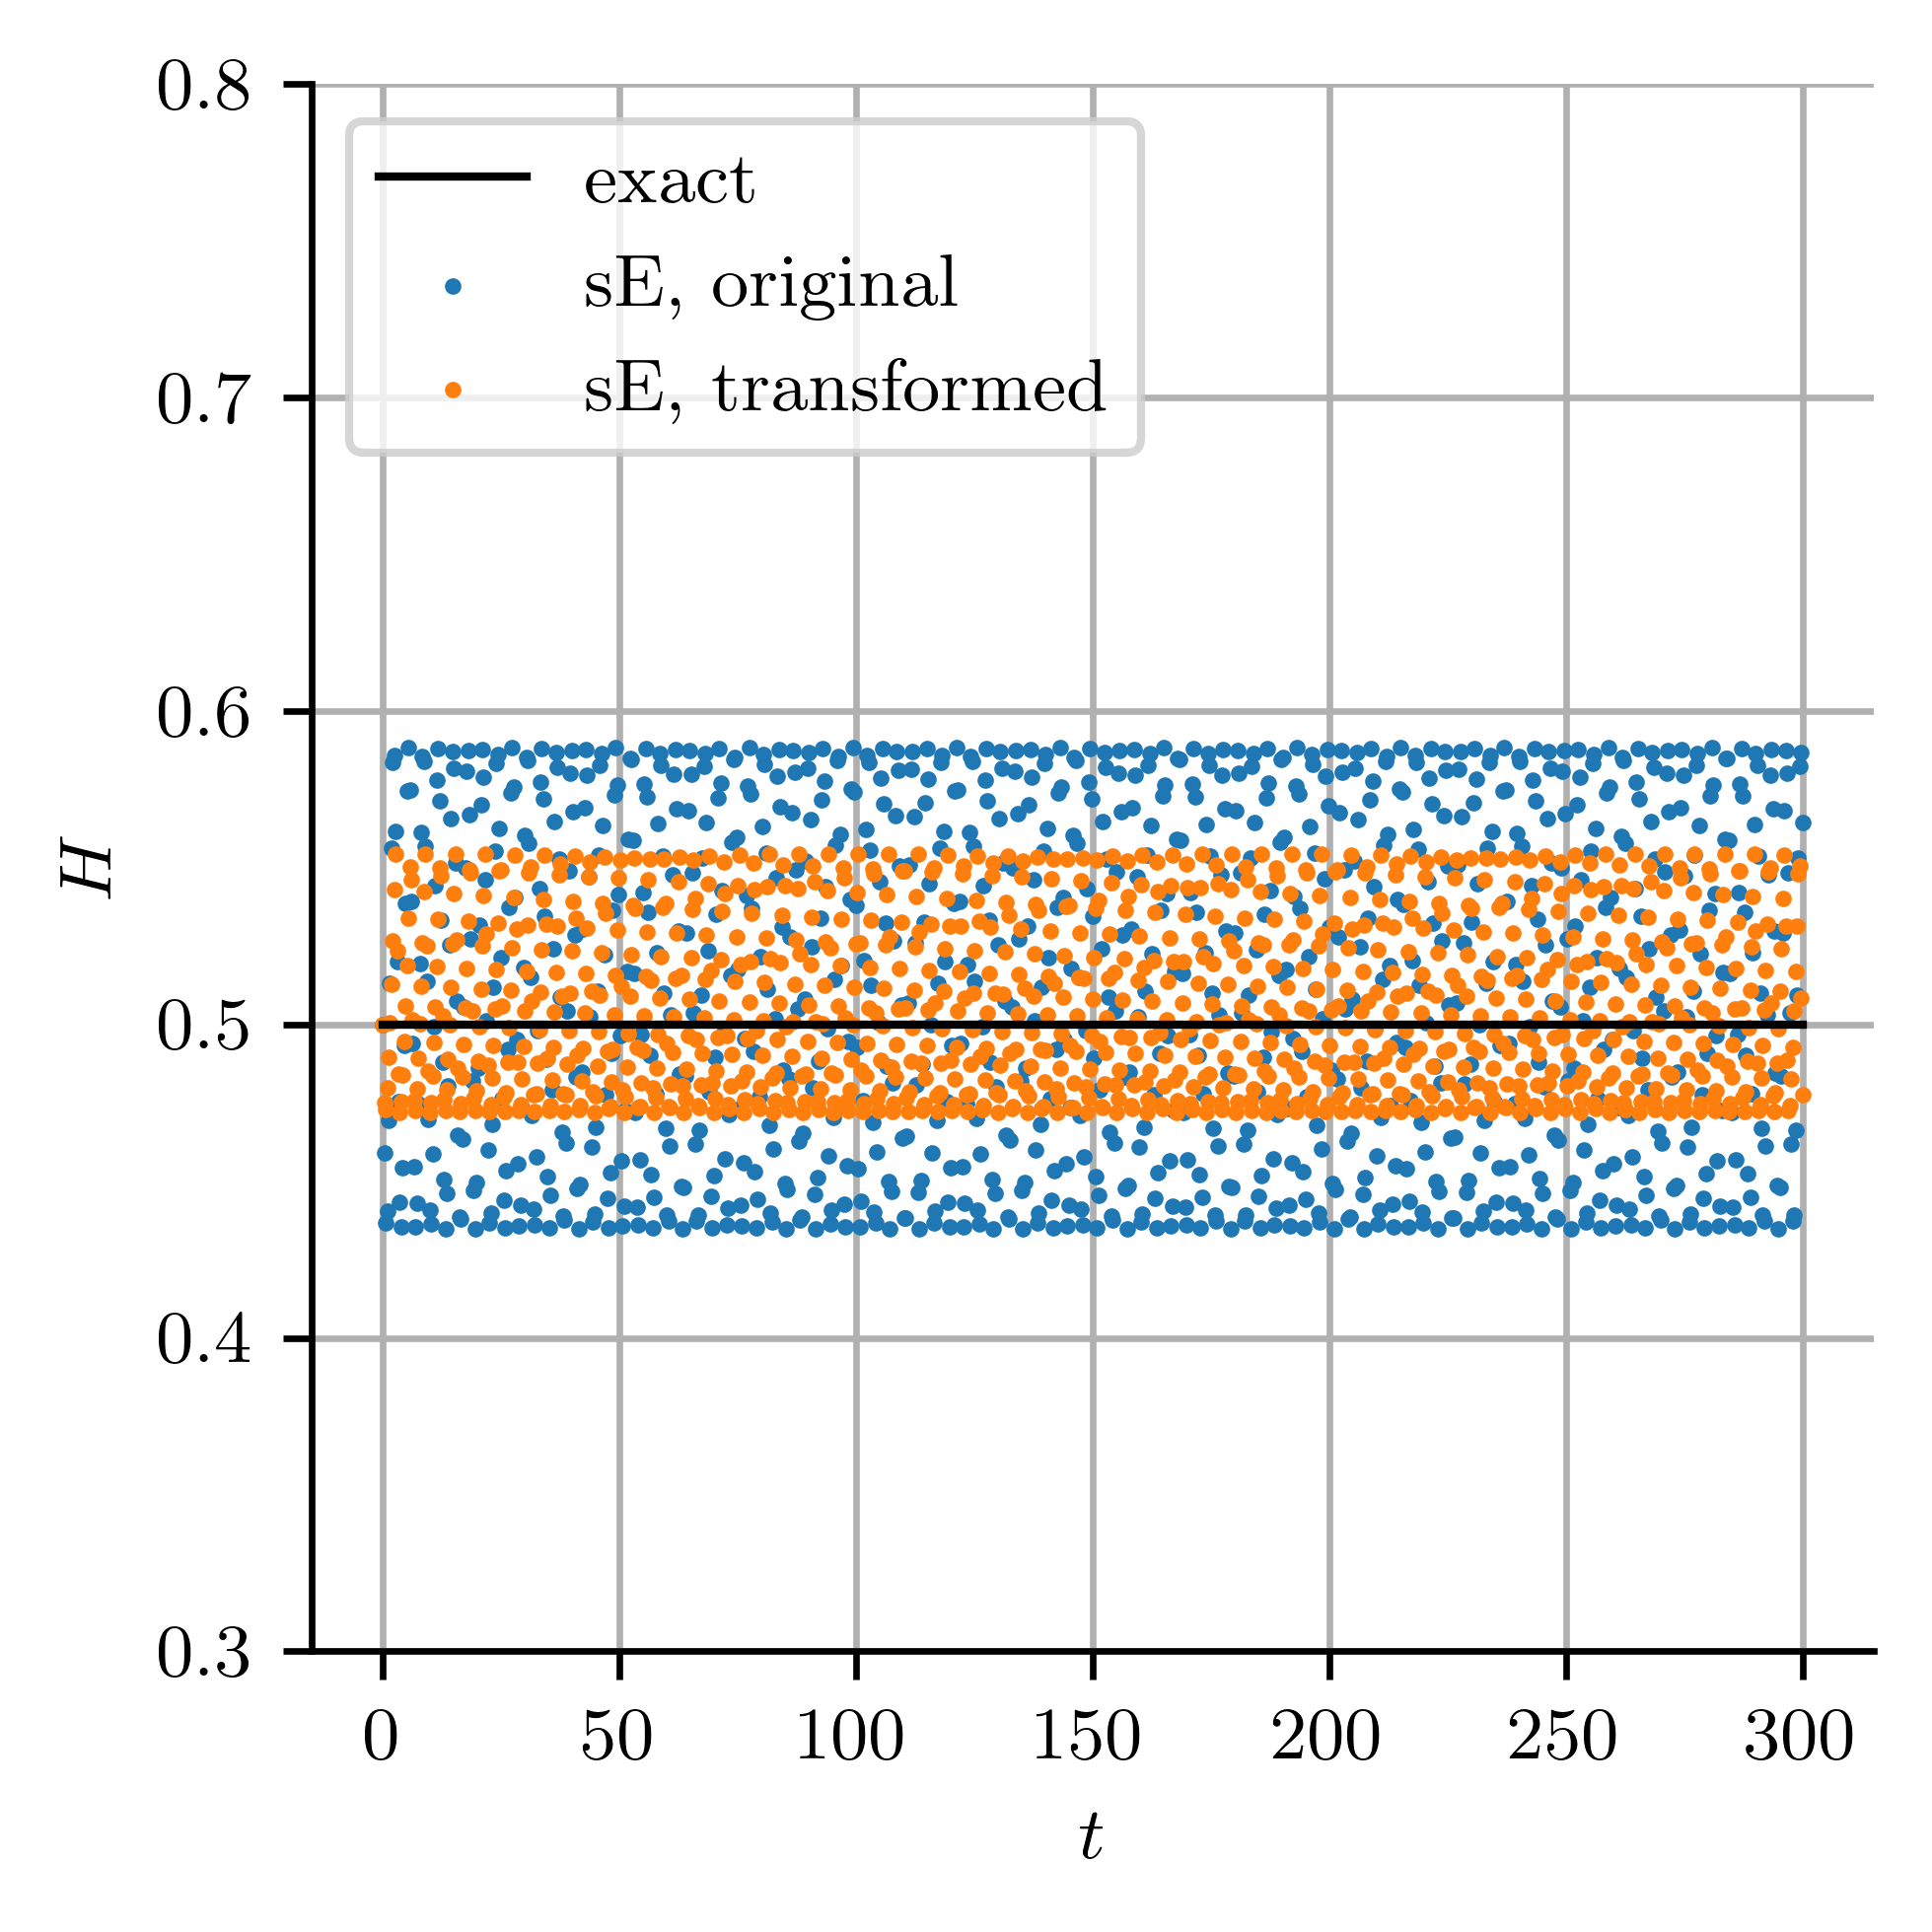

In [33]:
fig, ax = plt.subplots(1,1,figsize=(fig_width_mm*mm_to_in, fig_width_mm*mm_to_in),dpi=dpi)

t_plot = np.linspace(0, h*J, 1000)

ax.plot(t_plot, H(*exact_solution(t_plot)), color='k', lw=1, label='exact')

ax.scatter(t, H(q, p), s=1.0, label='sE, original')
ax.scatter(t, Hofbar, s=1.0, label='sE, transformed')

ax.set_ylim(0.3, 0.8)

ax.set_xlabel(r'$$t$$')
ax.set_ylabel(r'$$H$$')

ax.set_axisbelow(True)

ax.grid()

ax.legend(loc='upper left')
plt.savefig(graph_folder + '/harmonic_oscillator_transformed_H.png', bbox_inches='tight', facecolor='white')

plt.show()